# <font face = 'Impact' color = '#FFAEBC' > Sample Demonstration on Robust Regression <font/>
#### <font face = 'Times New Roman' color = '#B5E5CF'> License: GPL v3.0<font/>
#### <font face = 'Times New Roman' color = '#B5E5CF'> Author and Trainer: Paolo Hilado MSc. (Data Science)<font/>
This notebook provides a backgrounder in doing Robust Regression in Python. This approach is preferred when assumptions of multiple regression are missed out. Three approaches are introduced namely: Huber, Tukey, and Hampel

# Scenario
The operations unit would like to be informed of the variables that could explain good credit score among borrowers. In collaboration with the same unit you have been given access to their data set. The data set provided to you involves all the records of companies which bears variables relevant to credit scoring. The operations unit looks forward to the results of your analysis

In [2]:
# Load the necessary packages
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import qdesc as qd
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.diagnostic import het_breuschpagan

In [8]:
# Load your dataset
df = pd.read_excel('credit_risk_score.xlsx')
# Check out the first few records
df.head()

,AnnualRevenue,ProfitMargin,NumEmployees,YearsInOperation,Industry,HasPreviousDefaults,AvgMonthlyDebtObligation,CurrentLoanAmount,CollateralValue,FinancialStatementQuality,Region,CreditRiskScore
0,5.372018e+06,16.996777,48,19,Healthcare,0,20384.398702,579814.337716,825939.405284,5,West,10.554537
1,2.846884e+06,14.623168,47,26,Manufacturing,0,29319.250061,507097.856107,93672.826723,4,East,67.298342
2,6.247479e+06,10.298152,50,26,Healthcare,0,22538.061802,548087.263041,809158.936975,3,North,11.682366
3,1.499204e+07,6.765316,37,25,Healthcare,1,14843.385363,767623.082354,932309.562351,5,North,0.000000
4,2.586579e+06,13.491117,57,26,Finance,0,4870.969105,501459.017855,54753.956543,3,North,68.996762


In [9]:
# View information about the data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AnnualRevenue              1000 non-null   float64
 1   ProfitMargin               1000 non-null   float64
 2   NumEmployees               1000 non-null   int64  
 3   YearsInOperation           1000 non-null   int64  
 4   Industry                   1000 non-null   object 
 5   HasPreviousDefaults        1000 non-null   int64  
 6   AvgMonthlyDebtObligation   1000 non-null   float64
 7   CurrentLoanAmount          1000 non-null   float64
 8   CollateralValue            1000 non-null   float64
 9   FinancialStatementQuality  1000 non-null   int64  
 10  Region                     1000 non-null   object 
 11  CreditRiskScore            1000 non-null   float64
dtypes: float64(6), int64(4), object(2)
memory usage: 93.9+ KB


In [10]:
# Pre-process the data and indicate the explanatory variables and response variable.

# Indicate the response variable
target = 'CreditRiskScore'

# Separate target and predictors
y = df[target]
# Only include the relevant predictors
X = df.drop(columns=['CreditRiskScore'])

# One-hot encode categorical variables automatically
X_encoded = pd.get_dummies(X, drop_first=True)

# Add intercept (constant)
X_const = sm.add_constant(X_encoded)

# Convert all boolean columns to integers
bool_cols = X_const.select_dtypes(include='bool').columns
X_const[bool_cols] = X_const[bool_cols].astype(int)
model = sm.OLS(y, X_const).fit()

In [11]:
# Perform Exploratory Data Analysis
# Check Residual Normality - Preparation
residuals = model.resid # retrieve residuals
res = pd.DataFrame(residuals) # convert to dataframe
res.rename(columns={0: 'Residuals'}, inplace=True) # rename columns
res.head(3)

,Residuals
0,-18.101518
1,11.309478
2,-17.374524



--- Variable: Residuals ---
  Anderson-Darling Statistic : 9.4499
  Critical Value (@ 5.0%) : 0.7840
  Decision : Reject Null


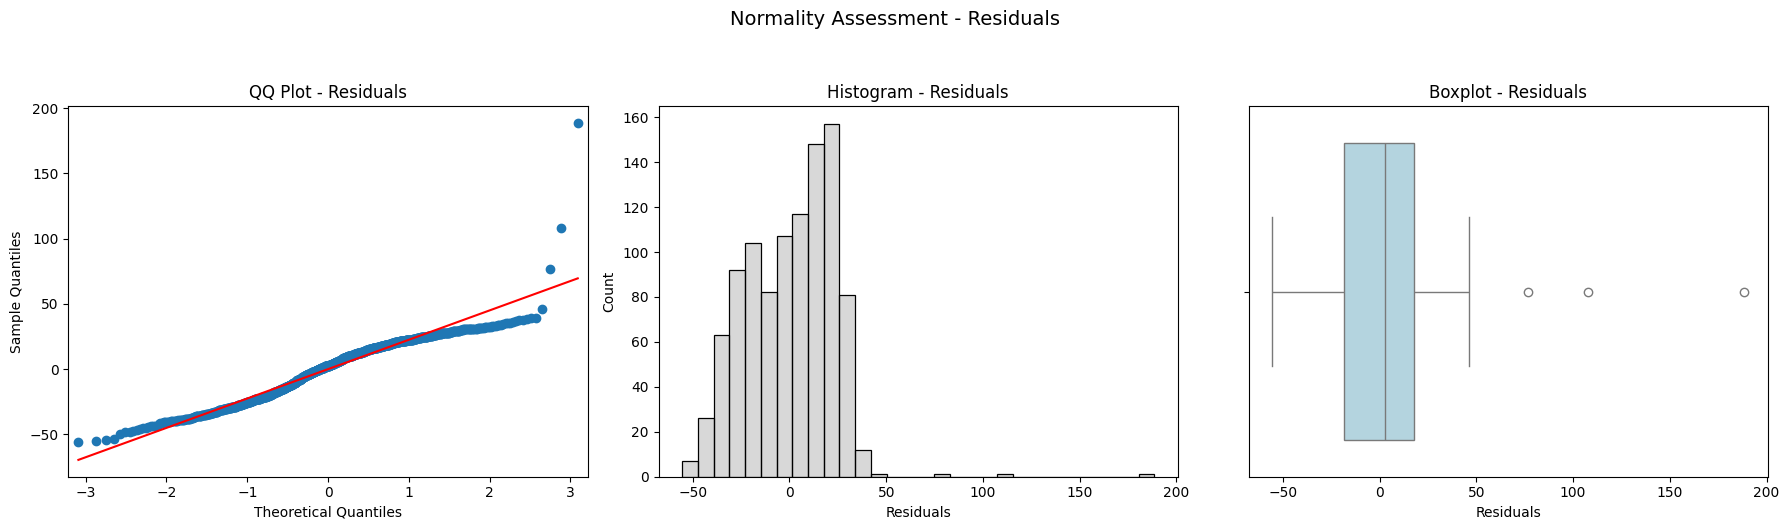

In [12]:
# Check Residual Normality - Normality Testing
qd.normcheck_dashboard(res)

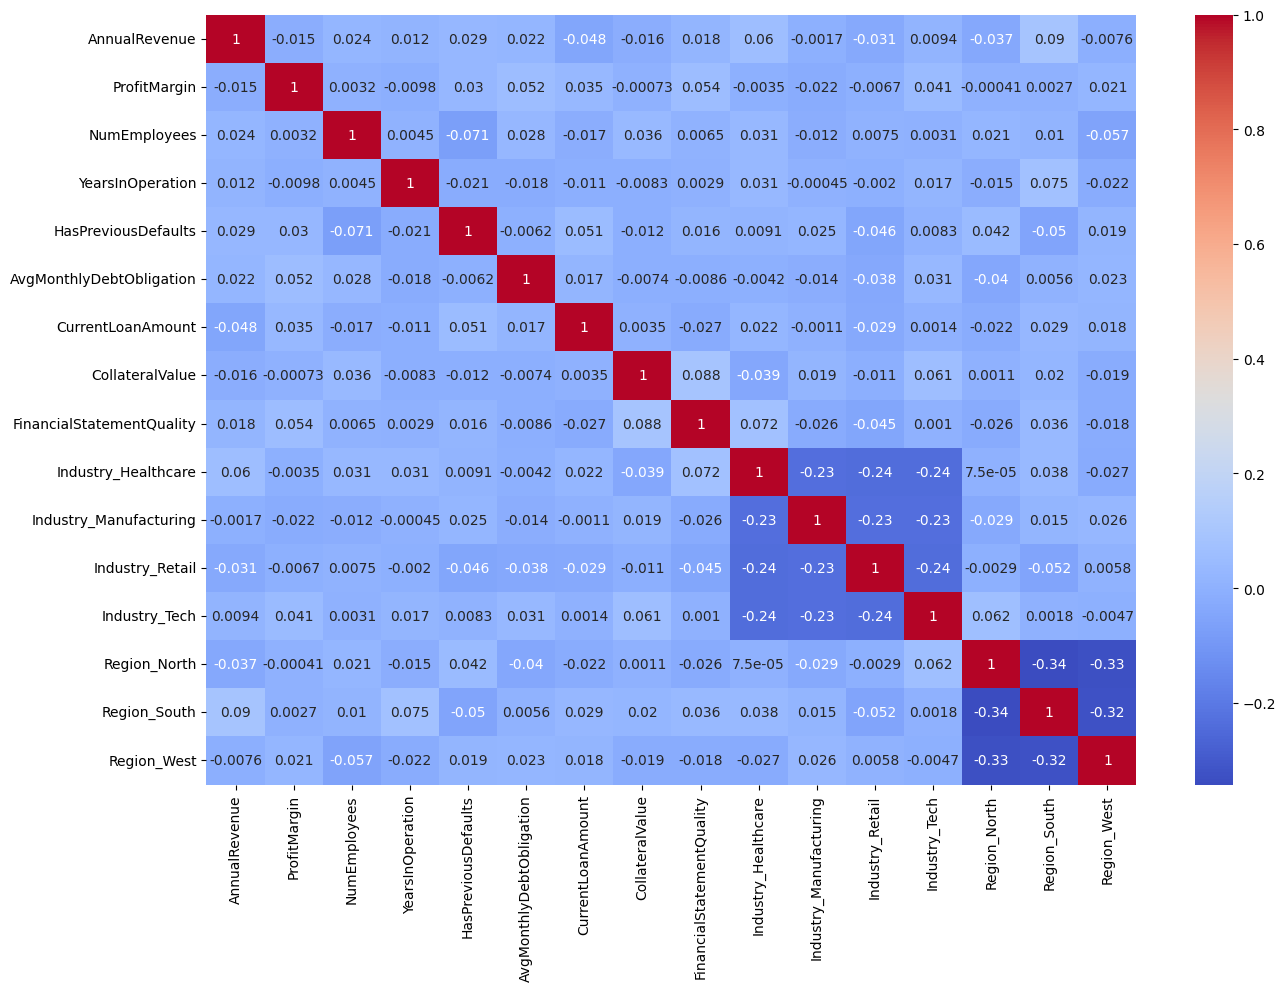

In [13]:
# Create a Correlation Matrix to check for Multicollinearity
plt.figure(figsize=(15, 10))
sns.heatmap(X_encoded.corr(), annot=True, cmap='coolwarm')
plt.show()

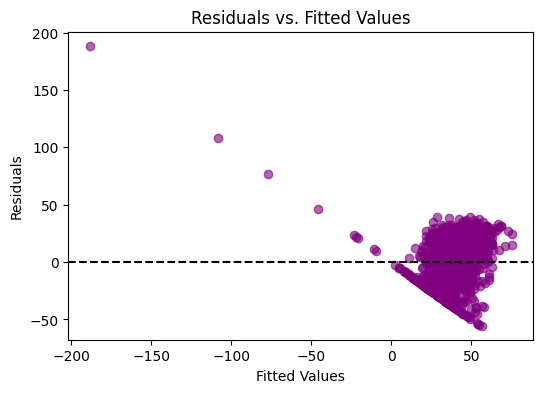

In [14]:
# Check Homoscedasticity (constant variance of residuals) - Visualization
plt.figure(figsize=(6, 4))
plt.scatter(model.fittedvalues, residuals, alpha=0.6, color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

In [16]:
# Check Homoscedasticity (constant variance of residuals) - Breusch-Pagan test
bp_test = het_breuschpagan(residuals, model.model.exog)
print(f"Breusch-Pagan test p-value: {bp_test[1]:.4f}")
if bp_test[1] > 0.05:
    print("Homoscedasticity assumption holds (fail to reject H0)")
else:
    print("Heteroscedasticity detected (reject H0)")

Breusch-Pagan test p-value: 0.0000
Heteroscedasticity detected (reject H0)


In [17]:
# Standardize all numeric columns
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X_encoded)
X_scaled = pd.DataFrame(X_scaled_array, columns=X_encoded.columns, index=X_encoded.index)
# 5. Add constant (intercept)
X_const = sm.add_constant(X_scaled)

In [18]:
# Huber robust regression
huber_model = sm.RLM(y, X_const, M=sm.robust.norms.HuberT())
huber_results = huber_model.fit()
print("\n=== Huber Robust Regression Summary ===\n")
print(huber_results.summary())


=== Huber Robust Regression Summary ===

                    Robust linear Model Regression Results                    
Dep. Variable:        CreditRiskScore   No. Observations:                 1000
Model:                            RLM   Df Residuals:                      983
Method:                          IRLS   Df Model:                           16
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 17 Oct 2025                                         
Time:                        16:13:33                                         
No. Iterations:                    41                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

In [19]:
# Tukey's Biweight robust regression
tukey_model = sm.RLM(y, X_const, M=sm.robust.norms.TukeyBiweight())
tukey_results = tukey_model.fit()
print("\n=== Tukey Robust Regression Summary ===\n")
print(tukey_results.summary())


=== Tukey Robust Regression Summary ===

                    Robust linear Model Regression Results                    
Dep. Variable:        CreditRiskScore   No. Observations:                 1000
Model:                            RLM   Df Residuals:                      983
Method:                          IRLS   Df Model:                           16
Norm:                   TukeyBiweight                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 17 Oct 2025                                         
Time:                        16:13:39                                         
No. Iterations:                    33                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

In [20]:
# Hampel robust regression
hampel_model = sm.RLM(y, X_const, M=sm.robust.norms.Hampel())
hampel_results = hampel_model.fit()
print("\n=== Hampel Robust Regression Summary ===\n")
print(hampel_results.summary())


=== Hampel Robust Regression Summary ===

                    Robust linear Model Regression Results                    
Dep. Variable:        CreditRiskScore   No. Observations:                 1000
Model:                            RLM   Df Residuals:                      983
Method:                          IRLS   Df Model:                           16
Norm:                          Hampel                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 17 Oct 2025                                         
Time:                        16:13:43                                         
No. Iterations:                    28                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------